# Training a Physics-Informed Neural Network (PINN) on the 1-d damped simple harmionic motion equation

I will fit a fully connected neural network to spatio-temporal data (one spatial and one time dimension). The neural network produces output that fits the observed data well, and also satisfies the 1d simple harmonic motion equation as a physical constraint. This makes it more suitable for prediction (extrapolation in time).

This initial section of this is based on the excellent blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). Read that one first and then come back here!

Download this page as a jupyter notebook: [Example_PINN.ipynb](Example_PINN.ipynb)

### Import required Libraries and class a network

In [ ]:
import os, shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from PIL import Image

In [5]:
class FCN(nn.Module):
    "Defines a fully connected neural network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


### Function to save results as a gif

In [4]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

### Set up the damped SHM equation


In [ ]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


### Plot the SHM equation

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


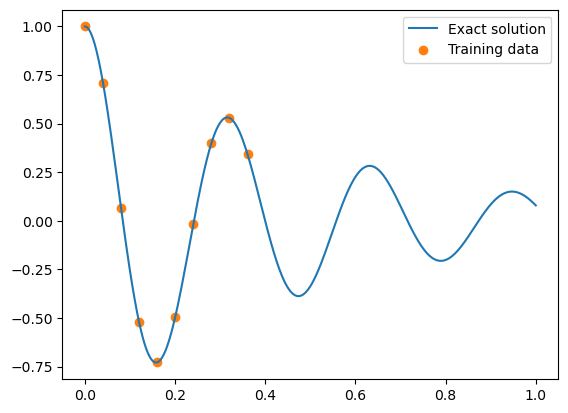

In [ ]:


d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()



In [7]:


class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        return outpt



In [8]:


def plot_result(x,y,x_data,y_data,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")



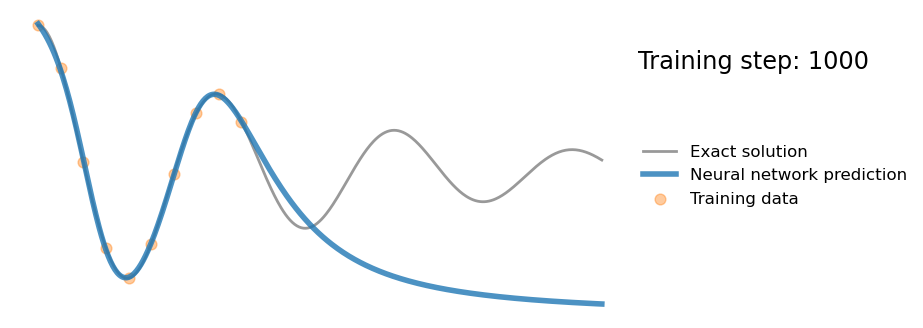

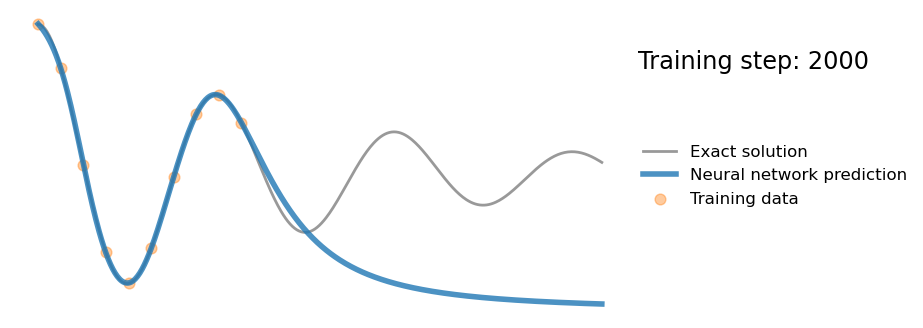

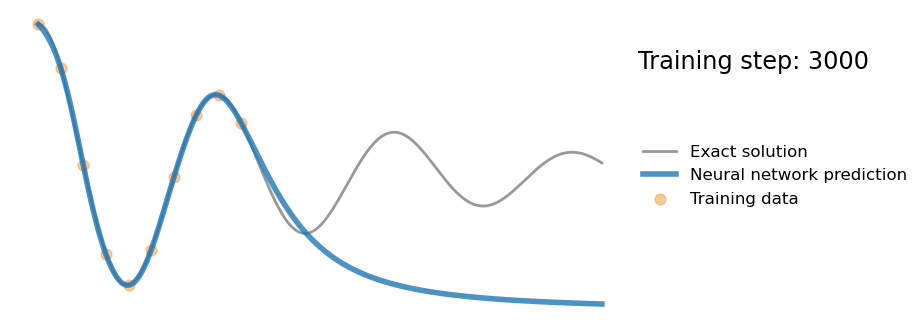

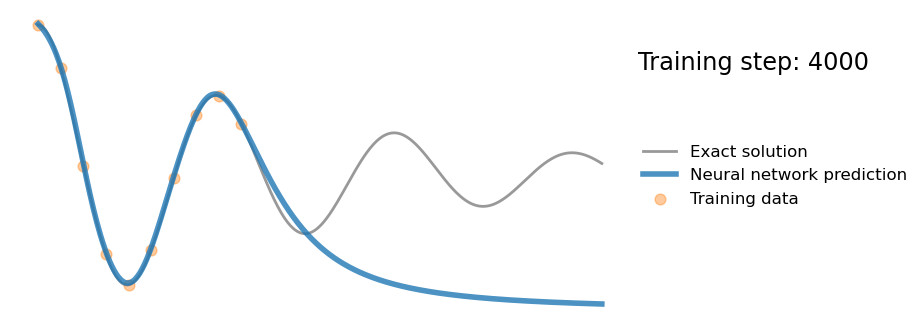

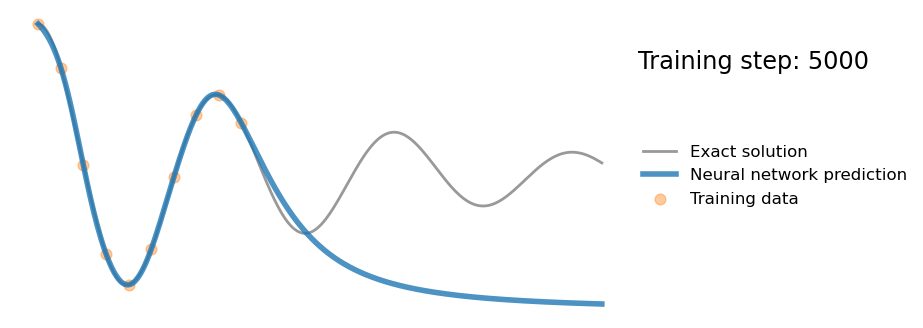

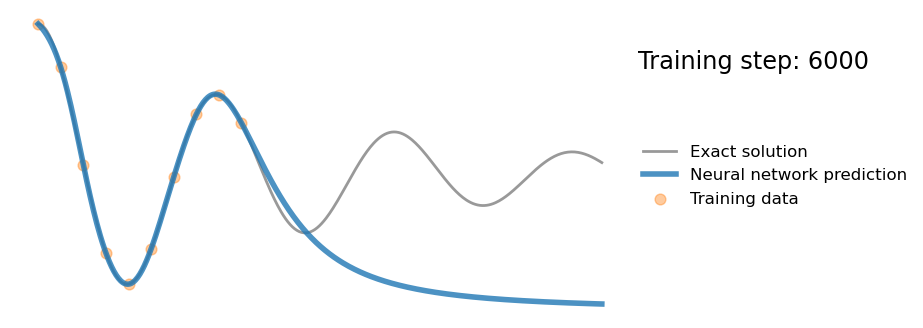

In [22]:


# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
os.makedirs("plots", exist_ok=True)

for i in range(6000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh, i)
        
#         file = "plots/nn_%.8i.png"%(i+1)
#         plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#         files.append(file)
    
        if (i+1) % 1000 == 0: plt.show()
        else: plt.close("all")
            
# save_gif_PIL("nn.gif", files, fps=20, loop=0)




In [13]:


def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    mu, k = 2*d, w0**2

#     torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    files = []
    epochs=6000
    losses = dict(dataloss=[], physicsloss=[])
    
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        dataloss = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = dataloss + physicsloss# add two loss terms together
        loss.backward()
        optimizer.step()
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")
    return losses



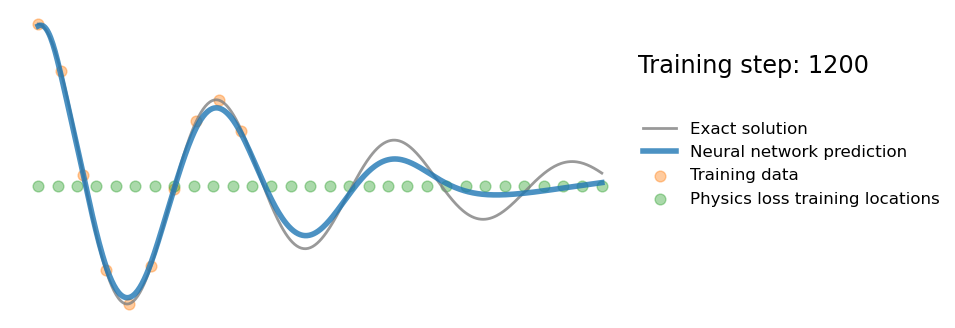

data physics loss tensor(0.0008, grad_fn=<MeanBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


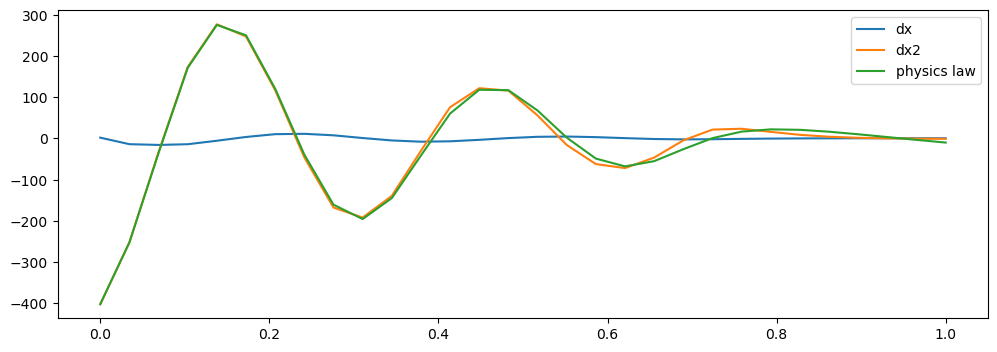

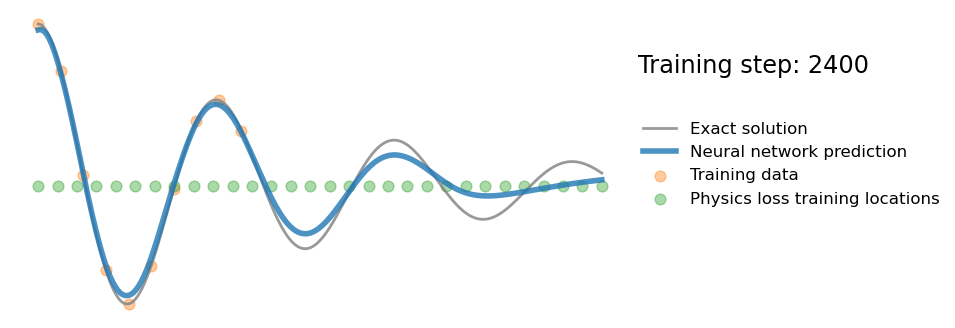

data physics loss tensor(0.0018, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


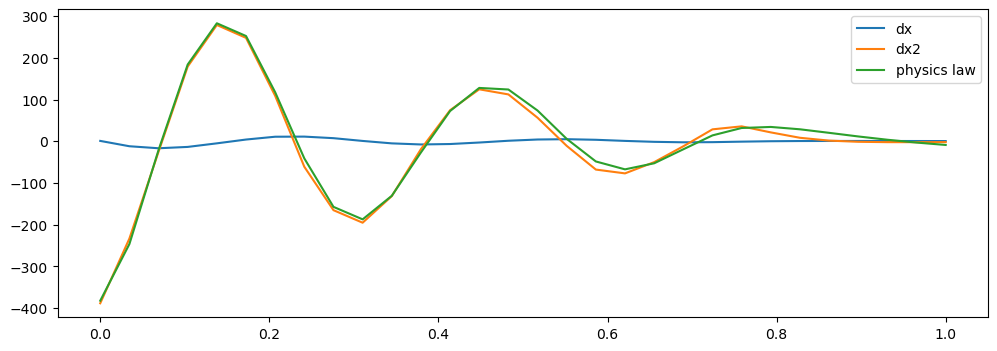

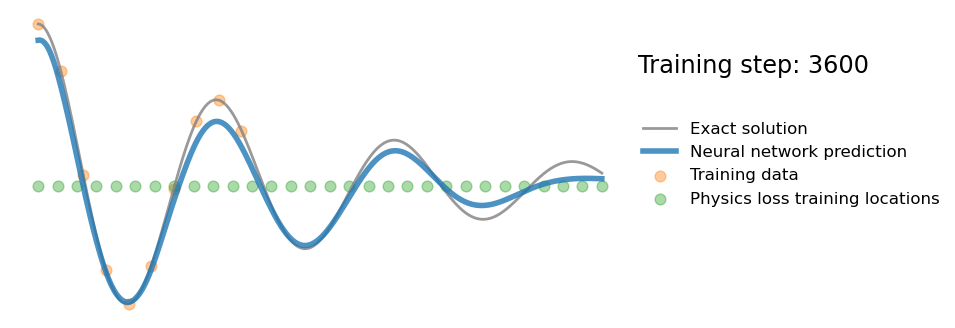

data physics loss tensor(0.0040, grad_fn=<MeanBackward0>) tensor(0.0232, grad_fn=<MulBackward0>)


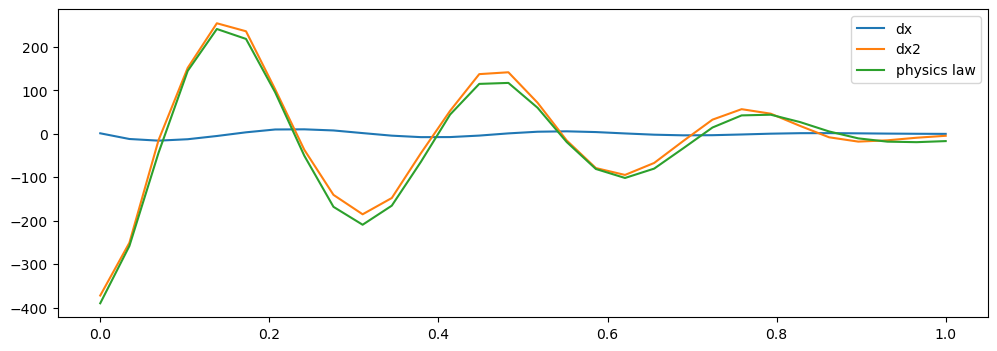

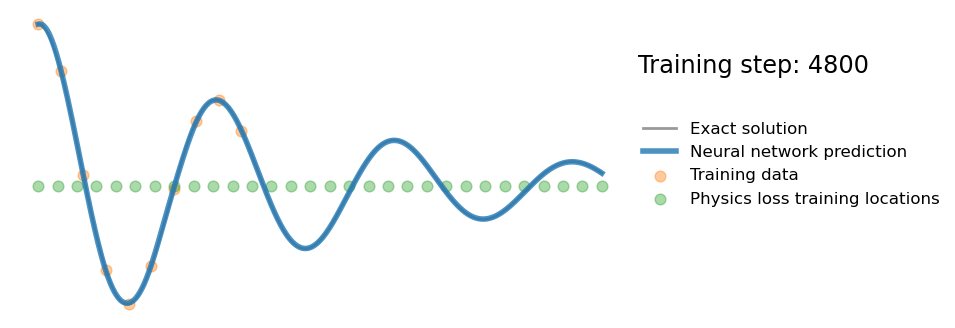

data physics loss tensor(1.2673e-05, grad_fn=<MeanBackward0>) tensor(1.3353e-05, grad_fn=<MulBackward0>)


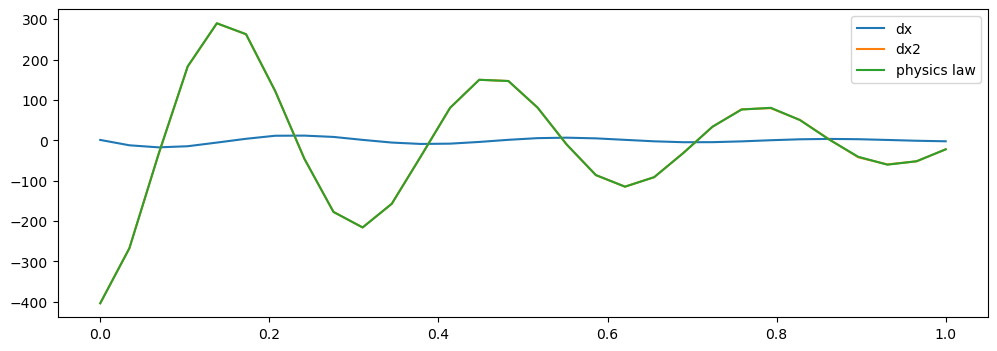

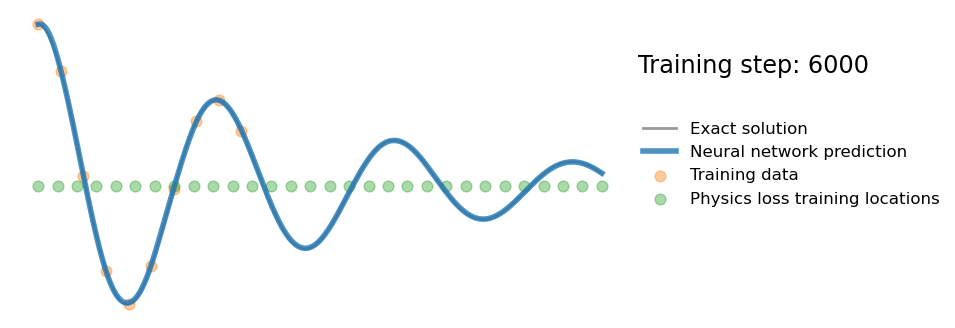

data physics loss tensor(1.0516e-05, grad_fn=<MeanBackward0>) tensor(3.9450e-05, grad_fn=<MulBackward0>)


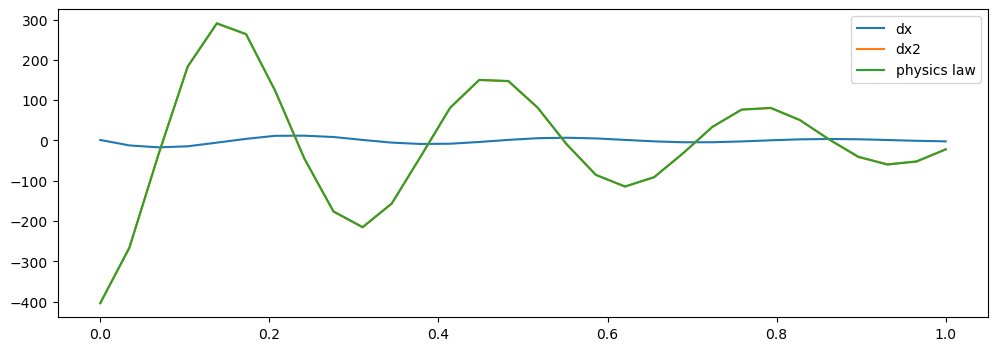

In [14]:


figs=[]
losses = train_oscillator()



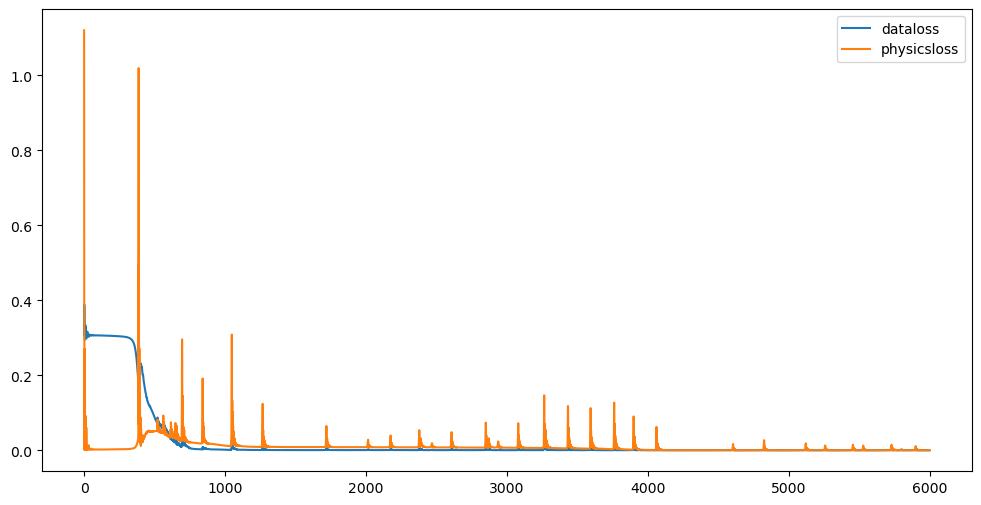

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
plt.legend()

In [444]:

class FullyConnected_iPINN(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        return outpt

In [476]:


def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    #mu, k = 2*d, w0**2
    mu_list = []
    k_list = []
    #k = w0**2
    print("The real mu is:", 2*d, "\n Our initial guess is:", 0.1)
    mu = torch.tensor([0.1], requires_grad = True)# initial guess for mu
    mu = torch.nn.Parameter(mu)
    mu_lr = 1e-1 # learning rate for mu

    print("The real k is:", w0**2, "\n Our initial guess is:", 500.0)
    k = torch.tensor([500.0], requires_grad = True)# initial guess for k
    k = torch.nn.Parameter(k)
    k_lr = 10 # 1e-1# learning rate for k

    #k = w0**2

#     torch.manual_seed(2022)
    model = FullyConnected_iPINN([1, 32, 32, 32, 1], activation=nn.Tanh)

    #optim = torch.optim.Adam(model.register_parameter, lr = mu_lr)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    mu_optim = torch.optim.Adam([mu], lr=mu_lr)
    k_optim = torch.optim.Adam([k], lr=k_lr)


    files = []
    epochs=18000
    losses = dict(dataloss=[], physicsloss=[])
    
    for i in range(epochs):
        optimizer.zero_grad()
        mu_optim.zero_grad()
        k_optim.zero_grad()



        # compute the "data loss"
        yh = model(x_data)
        dataloss = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = (1e-4)*torch.mean(physics**2)


        
        # backpropagate joint loss
        loss = 5*dataloss + physicsloss# add two loss terms together

        #dJdmu = torch.autograd.grad(loss, mu, create_graph=True, retain_graph=True)
        #mu.data = mu.data - dJdmu[0]*mu_lr

        #dJdk = torch.autograd.grad(loss, k, create_graph=True, retain_graph=True)
        #k.data = k.data - dJdk[0]*k_lr
        
        #mu.backward()
        loss.backward(retain_graph=True)
        optimizer.step()
        mu_optim.step()
        k_optim.step()
        
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 
            print("mu:", mu.data)
            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(4*dx + 400*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")
            mu_list.append(mu.data)
            k_list.append(k.data)
    return losses, mu, mu_list, k_list


The real mu is: 4 
 Our initial guess is: 0.1
The real k is: 400 
 Our initial guess is: 500.0
mu: tensor([5.2756])


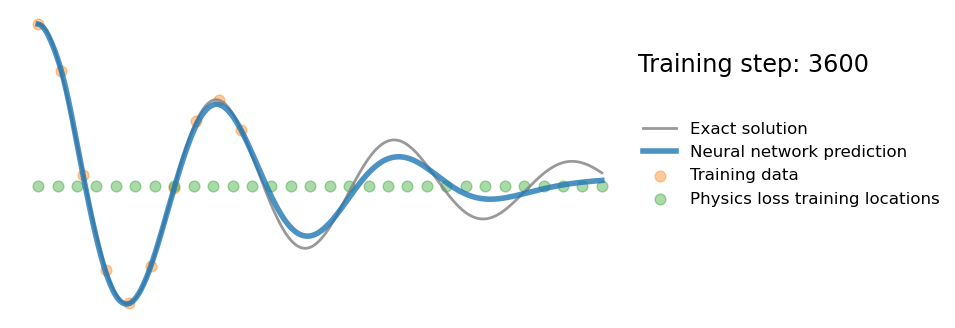

data physics loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)
mu: tensor([4.7314])


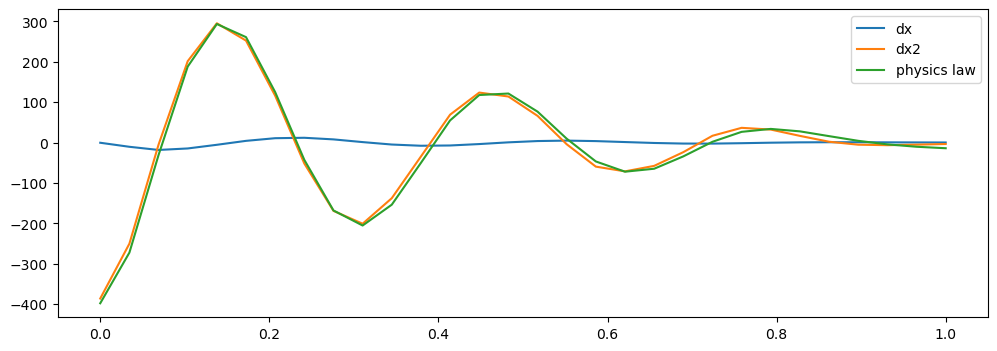

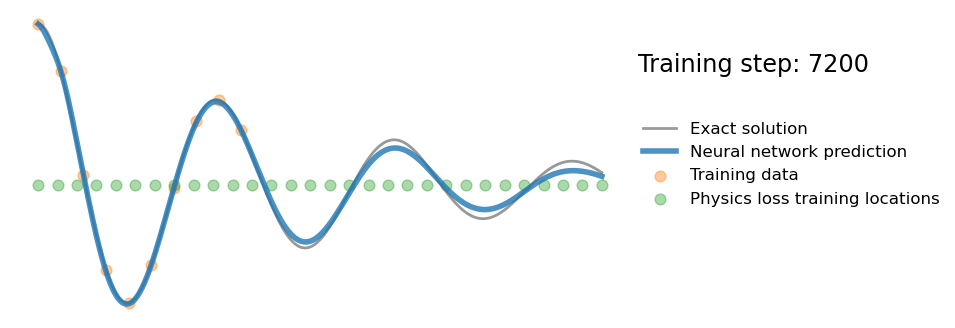

data physics loss tensor(4.2224e-05, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)
mu: tensor([4.1748])


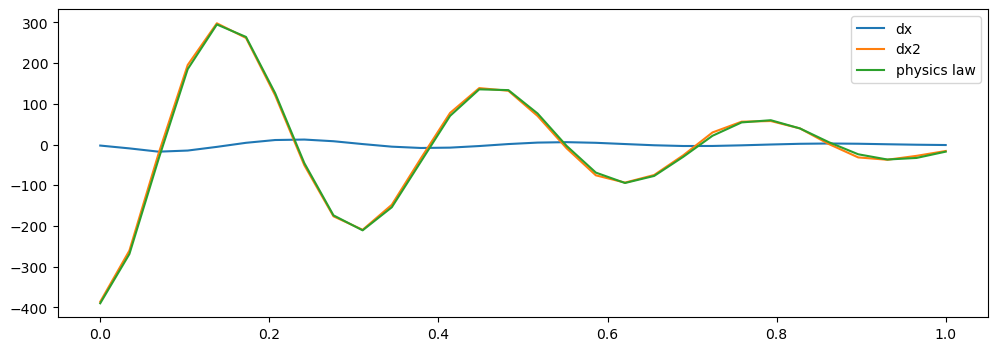

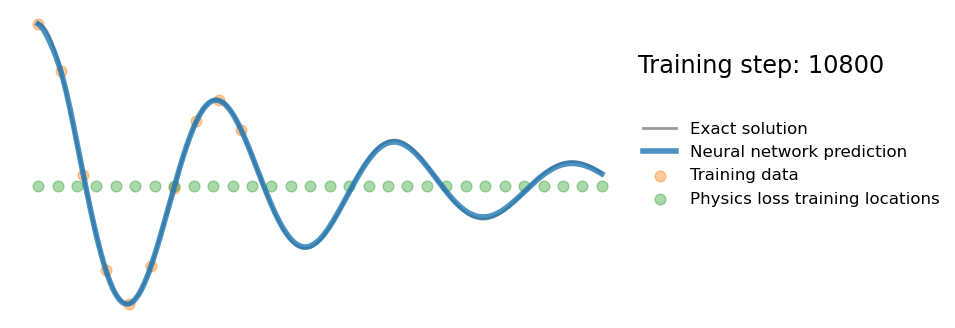

data physics loss tensor(3.1615e-06, grad_fn=<MeanBackward0>) tensor(4.4804e-05, grad_fn=<MulBackward0>)
mu: tensor([4.0516])


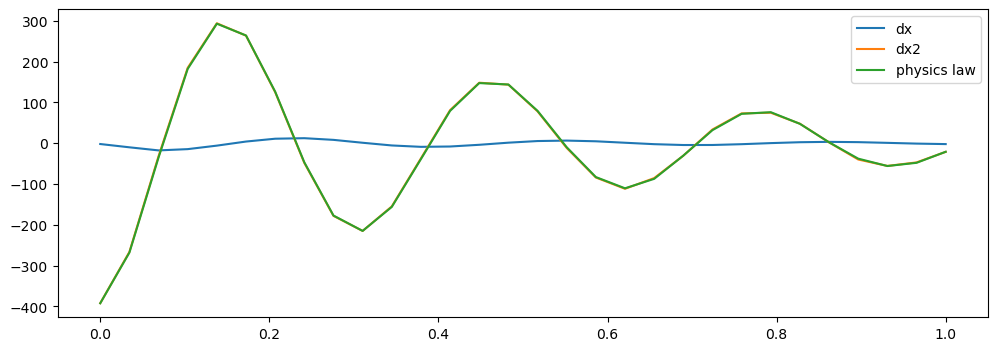

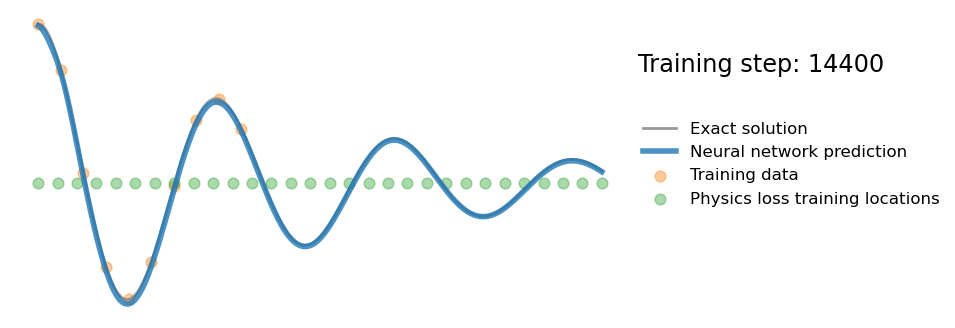

data physics loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)
mu: tensor([4.0250])


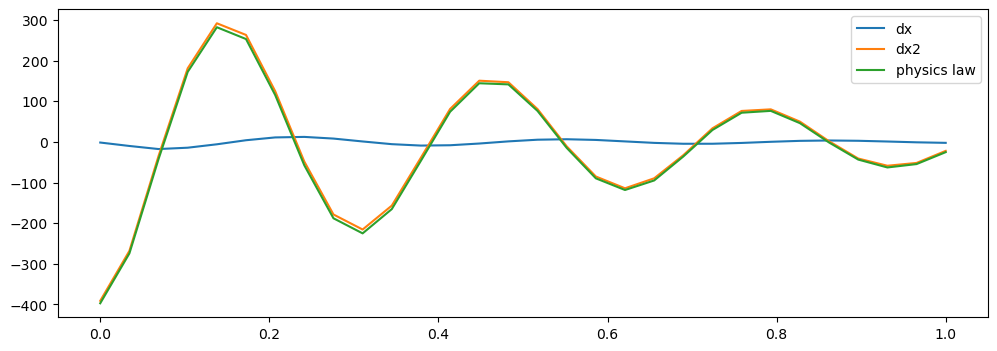

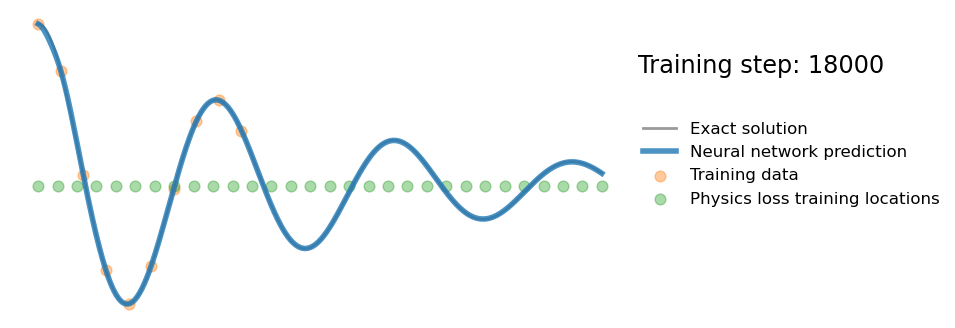

data physics loss tensor(1.1068e-07, grad_fn=<MeanBackward0>) tensor(4.2385e-06, grad_fn=<MulBackward0>)


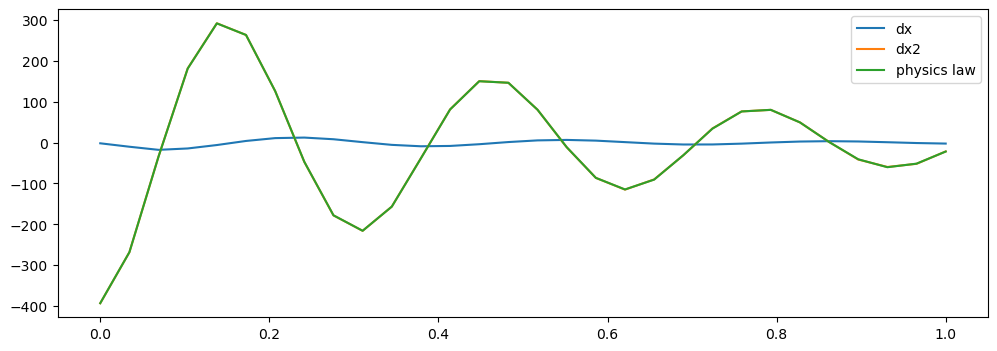

In [477]:
losses, mu, mu_list, k_list = train_oscillator()

In [ ]:
def plot_noisy_result(x,y,x_data,y_data_noisy,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [608]:
noise = np.random.normal(0,0.4,500)
# get the analytical solution over the full domain
y_noise = oscillator(d, w0, x).view(-1,1)

y_noise = y_noise + (0.1**0.5)*torch.randn(np.shape(y_noise))
# slice out a small number of points from the LHS of the domain
Noisy_y_data = y_noise[0:200:20]
np.shape(Noisy_y_data)

torch.Size([10, 1])

In [612]:
Noisy_y_data

tensor([[ 0.9808],
        [ 0.9532],
        [ 0.3017],
        [-0.2925],
        [-0.1609],
        [-0.3560],
        [ 0.2759],
        [ 0.4973],
        [ 0.6998],
        [ 0.3077]])

In [611]:
y_data

tensor([[ 1.0000],
        [ 0.7110],
        [ 0.0648],
        [-0.5221],
        [-0.7284],
        [-0.4943],
        [-0.0168],
        [ 0.3994],
        [ 0.5293],
        [ 0.3421]])

##Add Noiise to observational points##

In [613]:
def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    #mu, k = 2*d, w0**2
    mu_list = []
    k_list = []
    #k = w0**2
    print("The real mu is:", 2*d, "\n Our initial guess is:", 0.1)
    mu = torch.tensor([0.1], requires_grad = True)# initial guess for mu
    mu = torch.nn.Parameter(mu)
    mu_lr = 1e-1 # learning rate for mu

    print("The real k is:", w0**2, "\n Our initial guess is:", 500.0)
    k = torch.tensor([500.0], requires_grad = True)# initial guess for k
    k = torch.nn.Parameter(k)
    k_lr = 10 # 1e-1# learning rate for k

    #k = w0**2
    y_noise = oscillator(d, w0, x).view(-1,1)

    y_noise = y_noise + (0.1**0.5)*torch.randn(np.shape(y_noise))
    # slice out a small number of points from the LHS of the domain
    Noisy_y_data = y_noise[0:200:20]

#     torch.manual_seed(2022)
    model = FullyConnected_iPINN([1, 32, 32, 32, 1], activation=nn.Tanh)

    #optim = torch.optim.Adam(model.register_parameter, lr = mu_lr)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    mu_optim = torch.optim.Adam([mu], lr=mu_lr)
    k_optim = torch.optim.Adam([k], lr=k_lr)


    files = []
    epochs=50000
    losses = dict(dataloss=[], physicsloss=[])
    
    for i in range(epochs):
        optimizer.zero_grad()
        mu_optim.zero_grad()
        k_optim.zero_grad()



        # compute the "data loss"
        yh = model(x_data)
        dataloss = torch.mean((yh-Noisy_y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = (1e-3)*torch.mean(physics**2)


        
        # backpropagate joint loss
        loss = 3*dataloss + physicsloss# add two loss terms together

        #dJdmu = torch.autograd.grad(loss, mu, create_graph=True, retain_graph=True)
        #mu.data = mu.data - dJdmu[0]*mu_lr

        #dJdk = torch.autograd.grad(loss, k, create_graph=True, retain_graph=True)
        #k.data = k.data - dJdk[0]*k_lr
        
        #mu.backward()
        loss.backward(retain_graph=True)
        optimizer.step()
        mu_optim.step()
        k_optim.step()
        
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 
            print("mu:", mu.data)
            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,Noisy_y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(4*dx + 400*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")
            mu_list.append(mu.data)
            k_list.append(k.data)
            print("Loss 1 and 2:", dataloss, physicsloss)
    return losses, mu, mu_list, k_list


The real mu is: 4 
 Our initial guess is: 0.1
The real k is: 400 
 Our initial guess is: 500.0
mu: tensor([6.0652])


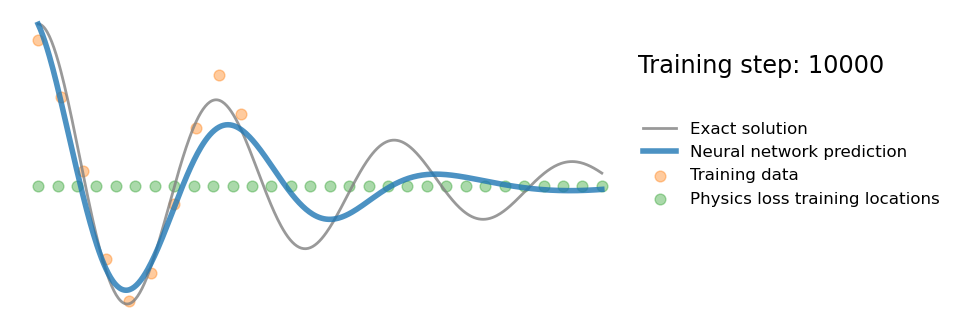

data physics loss tensor(0.0181, grad_fn=<MeanBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)
Loss 1 and 2: tensor(0.0181, grad_fn=<MeanBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)
mu: tensor([3.2108])


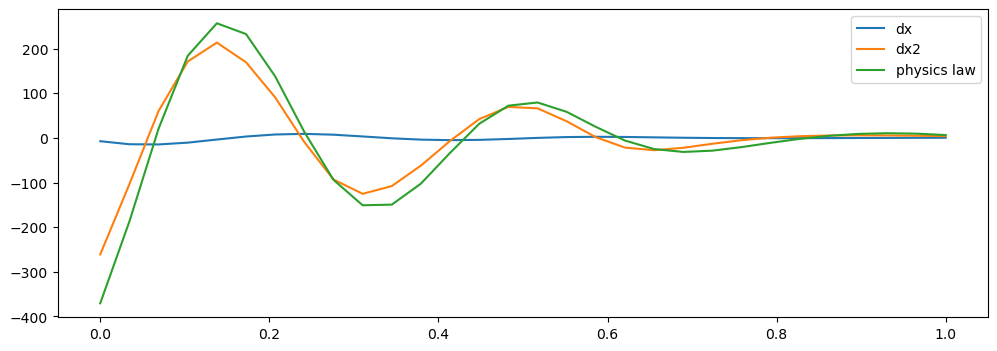

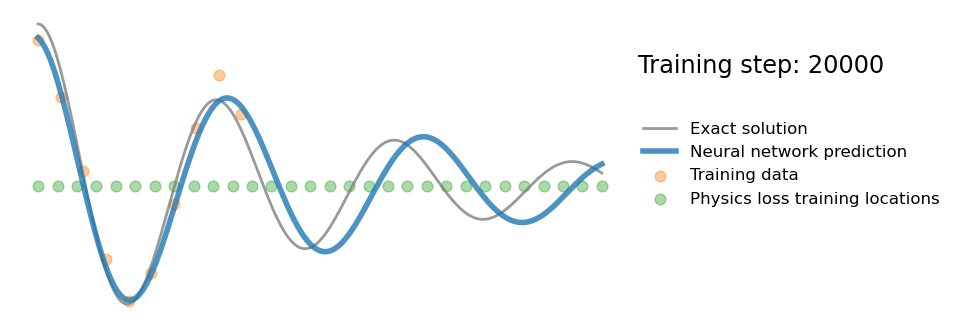

data physics loss tensor(0.0047, grad_fn=<MeanBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)
Loss 1 and 2: tensor(0.0047, grad_fn=<MeanBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)
mu: tensor([2.8207])


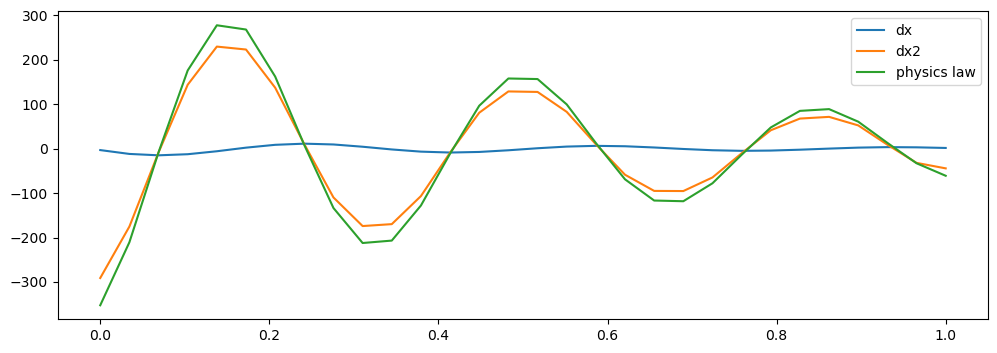

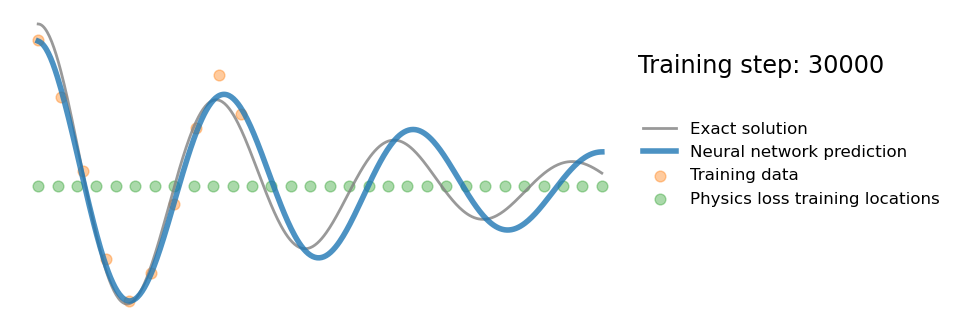

data physics loss tensor(0.0026, grad_fn=<MeanBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)
Loss 1 and 2: tensor(0.0026, grad_fn=<MeanBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)
mu: tensor([2.4552])


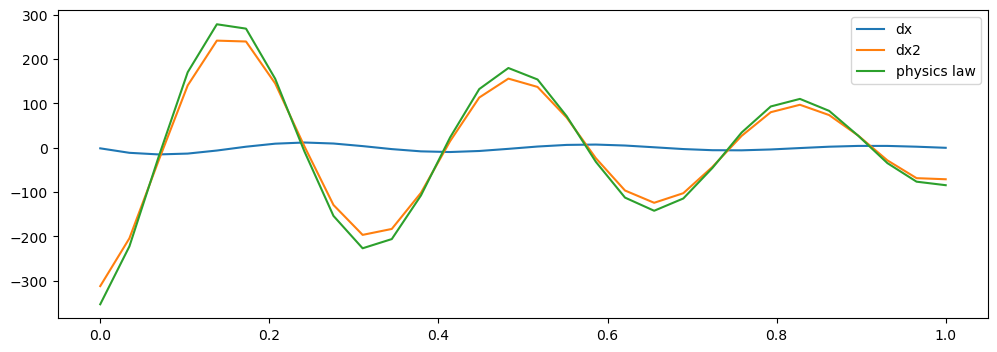

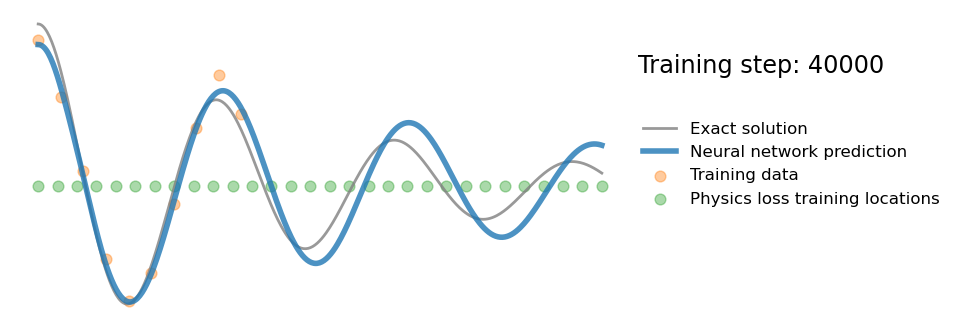

data physics loss tensor(0.0019, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)
Loss 1 and 2: tensor(0.0019, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)
mu: tensor([2.4570])


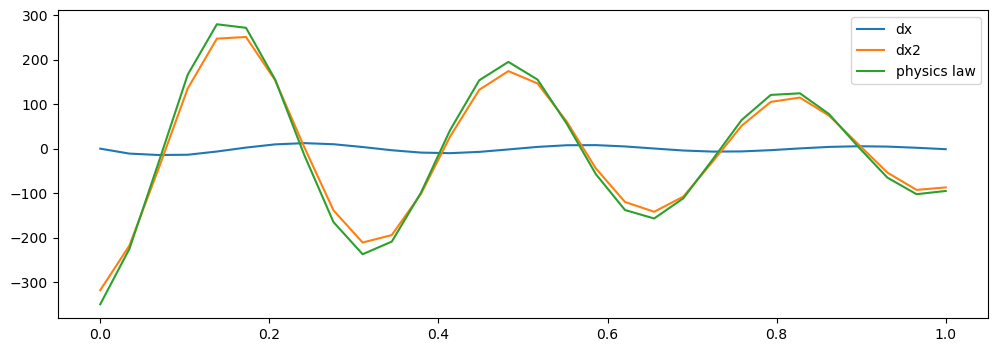

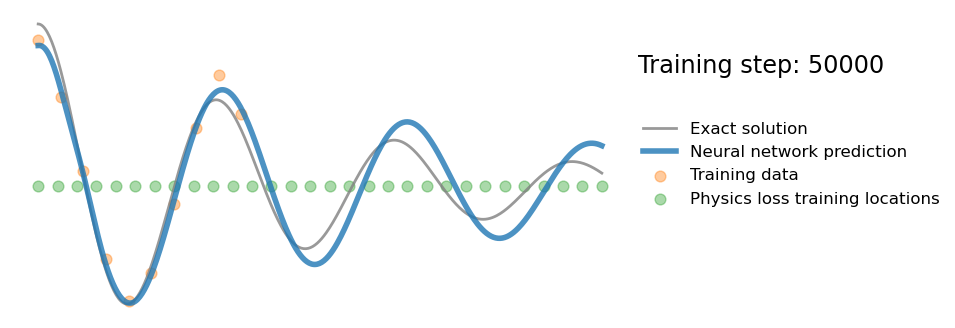

data physics loss tensor(0.0016, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)
Loss 1 and 2: tensor(0.0016, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


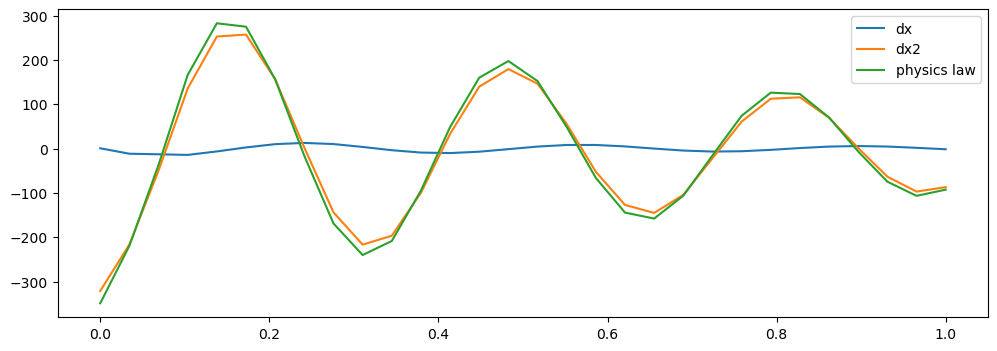

In [614]:
losses, mu, mu_list, k_list = train_oscillator()

In [615]:
mu

Parameter containing:
tensor([2.4570], requires_grad=True)

In [616]:
k_list

[tensor([369.1618]),
 tensor([369.1618]),
 tensor([369.1618]),
 tensor([369.1618]),
 tensor([369.1618])]

In [1]:
%%writefile ./.cdsapirc

UsageError: %%writefile is a cell magic, but the cell body is empty.
